# CNN Cancer Detection Kaggle Mini-Project

## Project Topic

This project is about identifying metastatic cancer in small image patches taken from larger digital pathology scans by using different Convolutional Neural Network (CNN) architectures.

In [1]:
# Mounting google drive to store the best models
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from PIL import Image

## Download Data Files from Kaggle

In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'histopathologic-cancer-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F11848%2F862157%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240613%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240613T152450Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D82b1f0f6ed7995950f25182edb43b47179727e0af8f6d9b80e62b4d6825a870921fa29f5db5d77e96cbf4448f6f182a1351a461e1e229c87caff68c65e576d2683744b4684950d8aff54a5ed5266e9adab9b243c3736006365322ea5471c250b8fc36c8e1a3ad642e10c443d1380631bf8ba26a8ba1ff1a993069a0bcf1b7d7f58f3cc9609d032a19fce48360abc1abd569c1d77c9c17063042895732113090e859b995719312334100d61c51a8fb73090f72b71068f74b751d7e00b44b454ef9ab8425bfdeda89615733f93cc952c367192e5e3243462e7a43434b1f4dd25c78ef094cf0fb40c25c15354229427f098c5e887a0e359ff14324537cd1ef168f5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 6773228425 bytes downloaded
Downloaded and uncompressed: histopathologic-cancer-detection
Data source import complete.


## The Dataset

The Dataset is a slightly modified version of the *PatchCamelyon (PCam)* benchmark dataset, comprised of 227,483 images, broken into two subsets, a `train` folder containing 220,025 images for training and a `test` folder containing 57,458 images for testing.

The `train_labels.csv` file provides the ground truth for the images in the `train` folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label.

The `sample_submission.csv` file provides the images to predict.

Source: https://www.kaggle.com/competitions/histopathologic-cancer-detection/data  

### Exploring the Data Files

First, let's take a look at the files within the created project folder.

In [4]:
# Display content of the project folder
proj_path = '/kaggle/input/histopathologic-cancer-detection'

# Display project main path sub-folders
proj_subfolders = next(os.walk(proj_path))[1]
print('Project sub-folders:', proj_subfolders)

# Display project main path files
proj_subfolders = next(os.walk(proj_path))[2]
print('Project main files:', proj_subfolders)

Project sub-folders: ['train', 'test']
Project main files: ['train_labels.csv', 'sample_submission.csv']


In [5]:
# Display first 5 files in the Train folder
train_path = proj_path+'/train/'
print('\n', 'First 5 files in train folder:')
for dirname, _, filenames in os.walk(train_path):
    for filename in filenames[:5]:
        print(os.path.join(dirname, filename))

# Display first 5 files in the Test folder
test_path = proj_path+'/test/'
print('\n', 'First 5 files in test folder:')
for dirname, _, filenames in os.walk(test_path):
    for filename in filenames[:5]:
        print(os.path.join(dirname, filename))


 First 5 files in train folder:
/kaggle/input/histopathologic-cancer-detection/train/7f8bfb37bbb429c17de5bd23bb8ea971042f33b1.tif
/kaggle/input/histopathologic-cancer-detection/train/b6584c520b27de215aee3cf8275df3f7d58d7216.tif
/kaggle/input/histopathologic-cancer-detection/train/d901ede6794042f89b012963e256d61412ae0ac0.tif
/kaggle/input/histopathologic-cancer-detection/train/a26e58e27e70075911e0fdf6bb294e2f1a7f25e6.tif
/kaggle/input/histopathologic-cancer-detection/train/55e6005333848c0728789b13a03833e390b0c747.tif

 First 5 files in test folder:
/kaggle/input/histopathologic-cancer-detection/test/fcd984198d8e9ad2d3432cac1e5f05b3a3431ee0.tif
/kaggle/input/histopathologic-cancer-detection/test/ee3c1012bb3cd492e583ad24e20aea260801570c.tif
/kaggle/input/histopathologic-cancer-detection/test/99cdd97a82ca5407dba868a0bc7086ef213889fe.tif
/kaggle/input/histopathologic-cancer-detection/test/4d90ad17b50b06e7203f3ae0bbbaedbe882783c3.tif
/kaggle/input/histopathologic-cancer-detection/test/4a35e

From the images files within the `train` and `test` folders, we realize that the image file format is `.tif`

Now, let's take a look at the images size.

In [6]:
# let's get a sample image
filepath = '/kaggle/input/histopathologic-cancer-detection/train/7bef3fa13250eacf755e91715e6db840cadda8c5.tif'
img = Image.open(filepath)

# Get width and height
img_width = img.width
img_height = img.height

# Display width and height
print("The height of the image is: ", img_height)
print("The width of the image is: ", img_width)

The height of the image is:  96
The width of the image is:  96


### Loading the Datasets

Let's upload the training and test sets into the dataset variables.

In [7]:
# Loading the training data
train = pd.read_csv(proj_path+'/train_labels.csv', dtype=str)

# Loading the test data
test = pd.read_csv(proj_path+'/sample_submission.csv', dtype=str)

## Exploratory Data Analysis

In this section, we'll inspect, visualize, clean and transform the data, in preparation for building and training the prediction models.

### Datasets Exploration

Let's get an insight of the datasets (i.e., size, type of data).

In [8]:
# Print training set shape
print('Size of the training set:',train.shape)

# Displaying the first 5 rows of the training set
# Print training set shape
train.head()

Size of the training set: (220025, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [9]:
# Types of data
print('Types of data in the training set:')
train.dtypes

Types of data in the training set:


id       object
label    object
dtype: object

In [10]:
# Print test set shape
print('Size of the test set:',test.shape)

# Displaying the first 5 rows of the test set
test.head()

Size of the test set: (57458, 2)


,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [11]:
# Types of data
print('Types of data in the test set:')
test.dtypes

Types of data in the test set:


id       object
label    object
dtype: object

From inspecting the datasets, we can observe that files in the `train` and `test` folders are named with the image `id` from the datasets.  

### Images Vizualization

Let's take a look at the first images from the training dataset.

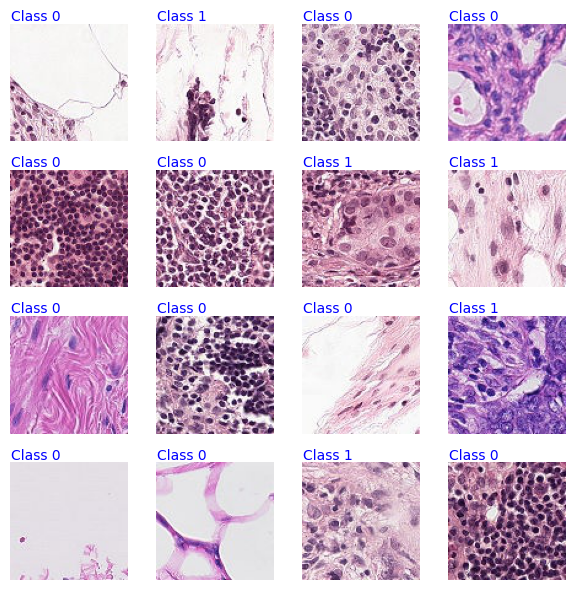

In [11]:
# Set size of the frame
plt.figure(figsize=(6,6))

# Define the text labels
detect_labels = {0: "Negative",  # index 0
                 1: "Positive"}  # index 1

# Display first 16 images of the training set
for i in range(16):

    img = mpimg.imread(f'/kaggle/input/histopathologic-cancer-detection/train/{train.iloc[i][0]}.tif')
    label = train.iloc[i][1]

    plt.subplot(4,4,i+1)
    plt.imshow(img)
    plt.text(0, -3, f'Class {label}', color='b')

    plt.axis('off')

plt.tight_layout()
plt.show()

### Label Distribution

Let's get an idea of the frequency of the labels in the training set by plotting a histogram:

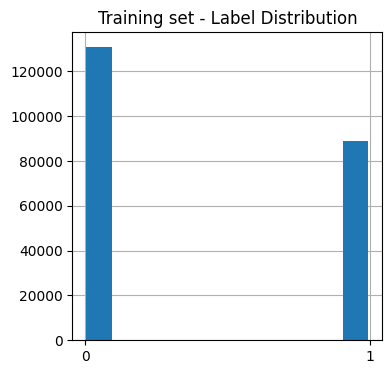

In [12]:
# Display Label Distribution
train['label'].hist(figsize=(4,4), zorder=2, rwidth=0.9)
plt.title('Training set - Label Distribution')
plt.show()

From the histogram, we can observe that the training data has got some class imbalance. It ocurrs when the classes are not represented equally, leading to bias towards the majority class.

### Images Filename

Before proceeding with the splitting of the training dataset into train and validation sets, let's add a new column with the image filename to ease the retrival of the image files.

In [13]:
# Add a new column (filename) with the image `id` + 'file format' into the training set
train['filename'] = train.id + '.tif'
train.head()

,id,label,filename
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif


In [14]:
# Next, for the test set
test['filename'] = test.id + '.tif'
test.head()

,id,label,filename
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif
1,95596b92e5066c5c52466c90b69ff089b39f2737,0,95596b92e5066c5c52466c90b69ff089b39f2737.tif
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif
3,2c35657e312966e9294eac6841726ff3a748febf,0,2c35657e312966e9294eac6841726ff3a748febf.tif
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif


### Split the Train Data

Now, let's split the `train` dataset into two datasets, one for training the model and one for validating the model. Additionally, we are applying stratification to mitigate the issue of class imbalance, and ensure that the minority class is equally represented in both, the training set and the validation set.

In [15]:
# Split training data into train / validation sets (80/20)

df_train, df_valid = train_test_split(train, test_size=0.2, random_state=42, stratify=train.label)

print('Size of the model training set:', df_train.shape)
print('Size of the model validation set:', df_valid.shape)

Size of the model training set: (176020, 3)
Size of the model validation set: (44005, 3)


### Images Transformation

Let's transform the images from `.tif` format into a source dataset (`tf.data.Dataset`) while applying transformation to data.



In [38]:
# Setting up ImageDataGenerator parameters to include Normalization
tif_to_tfdata = ImageDataGenerator(rescale=1/255)
batch_size = 64

tf_train = tif_to_tfdata.flow_from_dataframe(
    dataframe = df_train,
    directory = train_path,
    x_col = 'filename',
    y_col = 'label',
    batch_size = batch_size,
    target_size = (img_width, img_height)
)

tf_valid = tif_to_tfdata.flow_from_dataframe(
    dataframe = df_valid,
    directory = train_path,
    x_col = 'filename',
    y_col = 'label',
    batch_size = batch_size,
    target_size = (img_width, img_height),
    shuffle = False
)

tf_test = tif_to_tfdata.flow_from_dataframe(
    dataframe = test,
    directory = test_path,
    x_col = 'filename',
    y_col = 'label',
    batch_size = batch_size,
    target_size = (img_width, img_height),
    shuffle = False
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Found 57458 validated image filenames belonging to 1 classes.


`ImageDataGenerator` uses `batch_size=32` by default, let's look at how many batches were created.

In [41]:
# Determine number of batches per set
tf_train_batch = len(tf_train)
tf_valid_batch = len(tf_valid)
tf_test_batch = len(tf_test)
print('Number of batches')
print('train / validation / test')
print(tf_train_batch, '/', tf_valid_batch, '/', tf_test_batch)

# Look at first batch from train set
images, labels = next(tf_train)
print(images.shape, labels.shape)

Number of batches
train / validation / test
2751 / 688 / 898
(64, 96, 96, 3) (64, 2)


## Build and Train the Models

In training the model, we will employ two transfer-learning approaches. This involves using a pre-trained features extractor from the [Keras Applications](https://keras.io/api/applications/).  

We will test two different extractors as our base model:

* [VGG16](https://keras.io/api/applications/vgg/#vgg16-function)
* [MobileNet](https://keras.io/api/applications/mobilenet/)

and for the classifier, we will test two Multi-Layer Perceptron (MLP) architectures, each one with a different type of regularization that involves these Keras APIs:
*   [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/) - flatten the input
*   [Dense](https://keras.io/api/layers/core_layers/dense/) - regular densely-connected NN layer
*   [BatchNormalization](https://keras.io/api/layers/normalization_layers/batch_normalization/) - normalizes the inputs
*   [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) - apply drop out

but with the same number of layers:

* `BatchNormalizer` + `Flatten` + `Dense(16)` + `BatchNormalizer` + `Dense(8)` + `BatchNormalizer` + `Dense(2)`
* `Dropout` + `Flatten` + `Dense(16)` + `Dropout` + `Dense(8)` + `Dropout` + `Dense(2)`

### Visualize the Convergence of the Model Training

Before proceeding with the training, let's set a function that will allow us to visualize how the metrics (i.e., loss function) converge during the training process.

In [13]:
# Plot metrics vs epoch
def history_plot(model):
    # initiate dict
    hist_dict = {}
    # iterate across each metric
    for metric in model.history.keys():
        # extract metric values
        hist_dict[metric] = model.history[metric]

    # range of epoch
    epoch_range = range(1, len(hist_dict['loss'])+1)
    # set plot size
    plt.figure(figsize=[14,4])
    # number of sub-plots
    n = int(len(hist_dict.keys())/2)

    # iterate across number of sub-plots
    for i in range(n):
        # metric
        metric = list(hist_dict.keys())[i]
        # plot metric values
        plt.subplot(1,n,i+1)
        plt.plot(epoch_range, hist_dict[metric], label='Training')
        plt.plot(epoch_range, hist_dict['val_' + metric], label='Validation')
        plt.xlabel('epoch'); plt.ylabel(metric); plt.title(f'Convergence of {metric}')
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

### Models based on VGG16

For the training the models based on the features extractor VGG16, we will apply a typical transfer-learning workflow:
* Instantiate a base model and load pre-trained weights into it.
* Freeze all layers in the base model by setting `trainable = False`.
* Create a new model on top from the base model.
* Train the new model on the new dataset.
* Once the model has converged on the new data, unfreeze the base model and retrain the whole model end-to-end with a very low learning rate.

#### Base Model VGG16 + MLP Classifier with BatchNormalizer Regularization

##### 1. Initiation

In [31]:
# set seeds to ensure repeatibility of results
tf.random.set_seed(42)

# Pre-set the weights for the features extractor VGG16
fe_VGG16 = keras.applications.VGG16(
    input_shape=(96,96,3),
    include_top=False,
    pooling = None,
    weights='imagenet'
    )

# Display the base model architecture
fe_VGG16.summary()

# Freeze the base model weights
fe_VGG16.trainable = False

# Define the classifier on top of base model VGG16:
seq_VGG16_BN = Sequential([
               # features extractor
               fe_VGG16,

               # classifier
               BatchNormalization(),
               Flatten(),
               Dense(16, activation='relu'),
               BatchNormalization(),
               Dense(8, activation='relu'),
               BatchNormalization(),
               Dense(2, activation='softmax')
               ])

# Display the new model architecture
seq_VGG16_BN.summary()

# Compile the new model
seq_VGG16_BN.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy', tf.keras.metrics.AUC()])

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

##### 2. Training on new data

In [32]:
## Set a time counter
%%time

## Set checkpointer for best model
checkpointer = ModelCheckpoint(
                              filepath = '/content/drive/MyDrive/seq_VGG16_BN_1_weights_best.keras',
                              verbose = 1,
                              save_best_only=True
                              )

## Train model classifier side
mdl_VGG16_BN = seq_VGG16_BN.fit(
                    x = tf_train,
                    steps_per_epoch = tf_train_batch,
                    epochs = 15,
                    validation_data = tf_valid,
                    validation_steps = tf_valid_batch,
                    verbose = 1,
                    callbacks=[checkpointer]
                    )

Epoch 1/15
2751/2751 [==============================] - ETA: 0s - loss: 0.3419 - accuracy: 0.8513 - auc_4: 0.9280
Epoch 1: val_loss improved from inf to 0.30210, saving model to /content/drive/MyDrive/seq_VGG16_BN_1_weights_best.keras
2751/2751 [==============================] - 150s 54ms/step - loss: 0.3419 - accuracy: 0.8513 - auc_4: 0.9280 - val_loss: 0.3021 - val_accuracy: 0.8699 - val_auc_4: 0.9442
Epoch 2/15
2750/2751 [============================>.] - ETA: 0s - loss: 0.3015 - accuracy: 0.8708 - auc_4: 0.9444
Epoch 2: val_loss improved from 0.30210 to 0.29181, saving model to /content/drive/MyDrive/seq_VGG16_BN_1_weights_best.keras
2751/2751 [==============================] - 149s 54ms/step - loss: 0.3015 - accuracy: 0.8708 - auc_4: 0.9443 - val_loss: 0.2918 - val_accuracy: 0.8763 - val_auc_4: 0.9481
Epoch 3/15
2750/2751 [============================>.] - ETA: 0s - loss: 0.2830 - accuracy: 0.8803 - auc_4: 0.9510
Epoch 3: val_loss did not improve from 0.29181
2751/2751 [==========

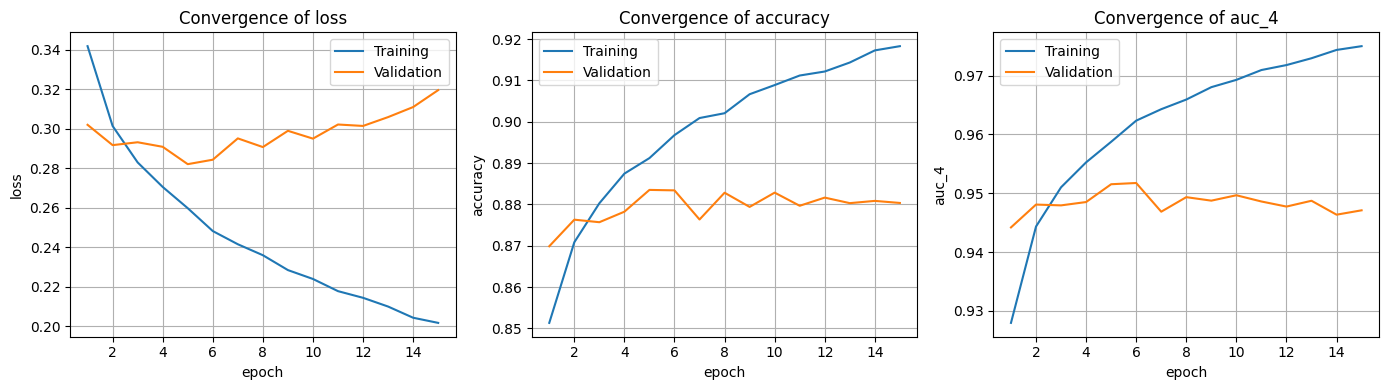

In [33]:
# monitor training convergence
history_plot(mdl_VGG16_BN)

From the covergence plots, we can observe that the training model converges around 5 epochs, then it begins to overfit from 6 epochs onwards.

##### 3. Fine-tuning the model

In [34]:
## Unfreeze the base model weights
fe_VGG16.trainable = True

## Recompile the model with a low learning rate
seq_VGG16_BN.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy', tf.keras.metrics.AUC()])

In [35]:
## Set a time counter
%%time

## Set checkpointer for best model
checkpointer = ModelCheckpoint(
                              filepath = '/content/drive/MyDrive/seq_VGG16_BN_2_weights_best.keras',
                              verbose = 1,
                              save_best_only=True
                              )

## Train whole model end-to-end
mdl_ft_VGG16_BN = seq_VGG16_BN.fit(
                    x = tf_train,
                    steps_per_epoch = tf_train_batch,
                    epochs = 10,
                    validation_data = tf_valid,
                    validation_steps = tf_valid_batch,
                    verbose = 1,
                    callbacks=[checkpointer]
                    )

Epoch 1/10
2751/2751 [==============================] - ETA: 0s - loss: 0.2274 - accuracy: 0.9104 - auc_5: 0.9690
Epoch 1: val_loss improved from inf to 0.22169, saving model to /content/drive/MyDrive/seq_VGG16_BN_2_weights_best.keras
2751/2751 [==============================] - 281s 100ms/step - loss: 0.2274 - accuracy: 0.9104 - auc_5: 0.9690 - val_loss: 0.2217 - val_accuracy: 0.9127 - val_auc_5: 0.9706
Epoch 2/10
2751/2751 [==============================] - ETA: 0s - loss: 0.1674 - accuracy: 0.9359 - auc_5: 0.9824
Epoch 2: val_loss improved from 0.22169 to 0.16307, saving model to /content/drive/MyDrive/seq_VGG16_BN_2_weights_best.keras
2751/2751 [==============================] - 276s 100ms/step - loss: 0.1674 - accuracy: 0.9359 - auc_5: 0.9824 - val_loss: 0.1631 - val_accuracy: 0.9387 - val_auc_5: 0.9830
Epoch 3/10
2751/2751 [==============================] - ETA: 0s - loss: 0.1387 - accuracy: 0.9475 - auc_5: 0.9876
Epoch 3: val_loss improved from 0.16307 to 0.15697, saving model t

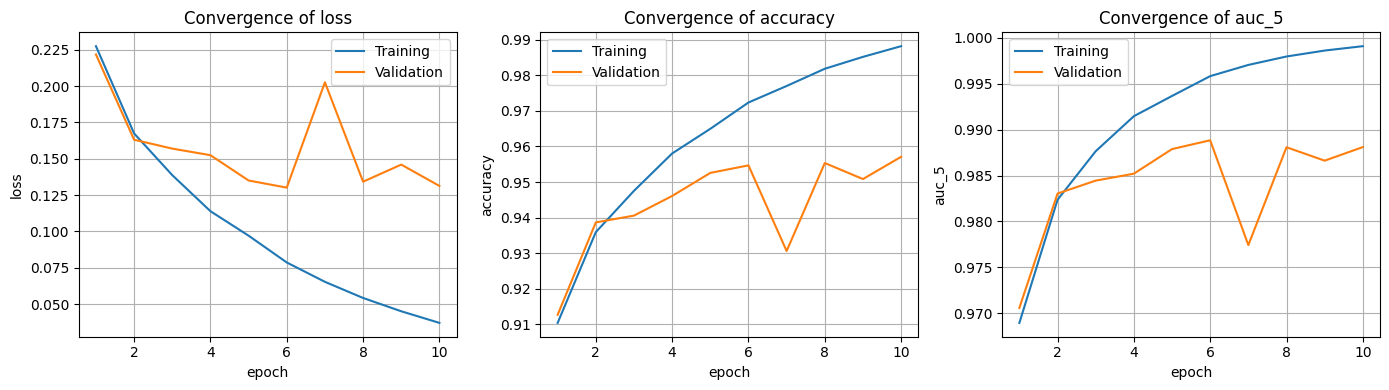

In [36]:
# monitor fine-tuning convergence
history_plot(mdl_ft_VGG16_BN)

The fine-tuning process significantly improved the performance of the model, reducing the validation loss by 52%.

From the convergence graphs, we can observe that even though the learning rate was very low, the validation loss oscillates distinctly. Further lowering the learning rate may be required to stabilize the loss.

#### Base Model VGG16 + MLP Classifier with Dropout Regularization

##### 1. Initiation

In [17]:
# set seeds to ensure repeatibility of results
tf.random.set_seed(42)

# Set the weights for the features extractor VGG16
fe_VGG16 = keras.applications.VGG16(
    input_shape=(96,96,3),
    include_top=False,
    pooling = None,
    weights='imagenet'
    )

# Display the base model architecture
fe_VGG16.summary()

# Freeze the base model weights
fe_VGG16.trainable = False

# Define the classifier on top of the base model VGG16
seq_VGG16_DO = Sequential([
                # features extractor
                fe_VGG16,

                # Classifier
                Dropout(0.3),
                Flatten(),
                Dense(16, activation='relu'),
                Dropout(0.5),
                Dense(8, activation='relu'),
                Dropout(0.5),
                Dense(2, activation='softmax')
                ])

# Display the new model architecture
seq_VGG16_DO.summary()

# Compile the new model
seq_VGG16_DO.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy', tf.keras.metrics.AUC()])

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

##### 2. Training on new data

In [18]:
## Set a time counter
%%time

# Set checkpointer
checkpointer = ModelCheckpoint(
                              filepath = '/content/drive/MyDrive/seq_VGG16_DO_1_weights_best.keras',
                              verbose = 1,
                              save_best_only=True
                              )

# Train model classifier side
mdl_VGG16_DO = seq_VGG16_DO.fit(
                    x = tf_train,
                    steps_per_epoch = tf_train_batch,
                    epochs = 15,
                    validation_data = tf_valid,
                    validation_steps = tf_valid_batch,
                    verbose = 1,
                    callbacks=[checkpointer]
                    )

Epoch 1/15
2750/2751 [============================>.] - ETA: 0s - loss: 0.5572 - accuracy: 0.6751 - auc_1: 0.7671
Epoch 1: val_loss improved from inf to 0.40704, saving model to /content/drive/MyDrive/seq_VGG16_DO_1_weights_best.keras
2751/2751 [==============================] - 157s 56ms/step - loss: 0.5572 - accuracy: 0.6750 - auc_1: 0.7671 - val_loss: 0.4070 - val_accuracy: 0.8349 - val_auc_1: 0.9113
Epoch 2/15
2750/2751 [============================>.] - ETA: 0s - loss: 0.5367 - accuracy: 0.6807 - auc_1: 0.7822
Epoch 2: val_loss improved from 0.40704 to 0.39741, saving model to /content/drive/MyDrive/seq_VGG16_DO_1_weights_best.keras
2751/2751 [==============================] - 146s 53ms/step - loss: 0.5367 - accuracy: 0.6807 - auc_1: 0.7822 - val_loss: 0.3974 - val_accuracy: 0.8443 - val_auc_1: 0.9235
Epoch 3/15
2750/2751 [============================>.] - ETA: 0s - loss: 0.5315 - accuracy: 0.6822 - auc_1: 0.7850
Epoch 3: val_loss did not improve from 0.39741
2751/2751 [==========

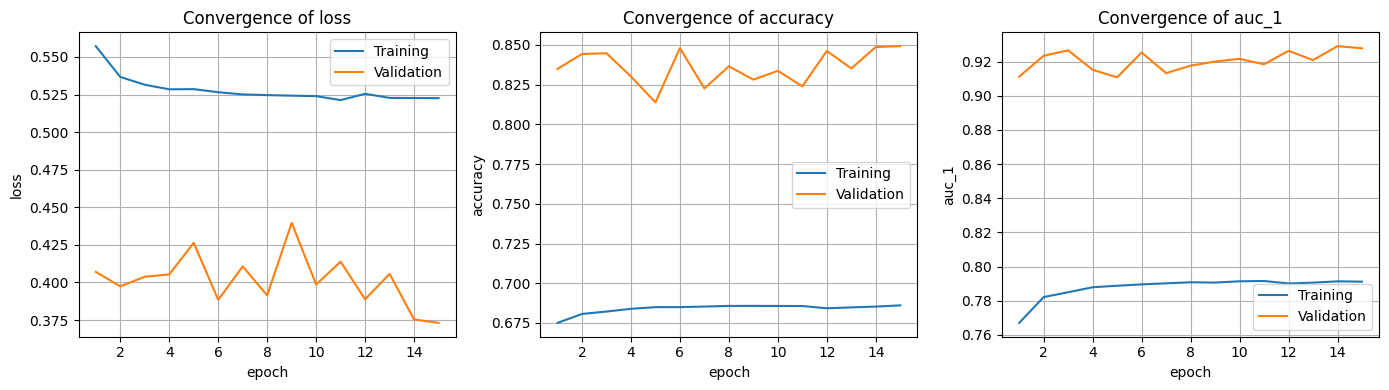

In [19]:
# monitor training convergence
history_plot(mdl_VGG16_DO)

From the convergence plots, we can observe that from the 8th epoch, the training loss has leveled off, however, the validation loss is gradually improving with each epoch.

Additionally, we can observe that the validation loss is lower than the training loss. This is caused by the presence of dropout regularization in the model achitecture, as the dropout layers are only active during training but disabled during validation.

##### 3. Fine-tuning the model

In [20]:
## Unfreeze the base model weights
fe_VGG16.trainable = True

## Recompile the model with a low learning rate
seq_VGG16_DO.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy', tf.keras.metrics.AUC()])

In [21]:
## Set a time counter
%%time

## Set checkpointer for best model
checkpointer = ModelCheckpoint(
                              filepath = '/content/drive/MyDrive/seq_VGG16_DO_2_weights_best.keras',
                              verbose = 1,
                              save_best_only=True
                              )

## Train whole model end-to-end
mdl_ft_VGG16_DO = seq_VGG16_DO.fit(
                    x = tf_train,
                    steps_per_epoch = tf_train_batch,
                    epochs = 10,
                    validation_data = tf_valid,
                    validation_steps = tf_valid_batch,
                    verbose = 1,
                    callbacks=[checkpointer]
                    )

Epoch 1/10
2751/2751 [==============================] - ETA: 0s - loss: 0.4868 - accuracy: 0.7006 - auc_2: 0.8170
Epoch 1: val_loss improved from inf to 0.25455, saving model to /content/drive/MyDrive/seq_VGG16_DO_2_weights_best.keras
2751/2751 [==============================] - 304s 107ms/step - loss: 0.4868 - accuracy: 0.7006 - auc_2: 0.8170 - val_loss: 0.2546 - val_accuracy: 0.9183 - val_auc_2: 0.9740
Epoch 2/10
2751/2751 [==============================] - ETA: 0s - loss: 0.4387 - accuracy: 0.7164 - auc_2: 0.8421
Epoch 2: val_loss improved from 0.25455 to 0.22282, saving model to /content/drive/MyDrive/seq_VGG16_DO_2_weights_best.keras
2751/2751 [==============================] - 284s 103ms/step - loss: 0.4387 - accuracy: 0.7164 - auc_2: 0.8421 - val_loss: 0.2228 - val_accuracy: 0.9178 - val_auc_2: 0.9737
Epoch 3/10
2751/2751 [==============================] - ETA: 0s - loss: 0.4170 - accuracy: 0.7498 - auc_2: 0.8642
Epoch 3: val_loss improved from 0.22282 to 0.17464, saving model t

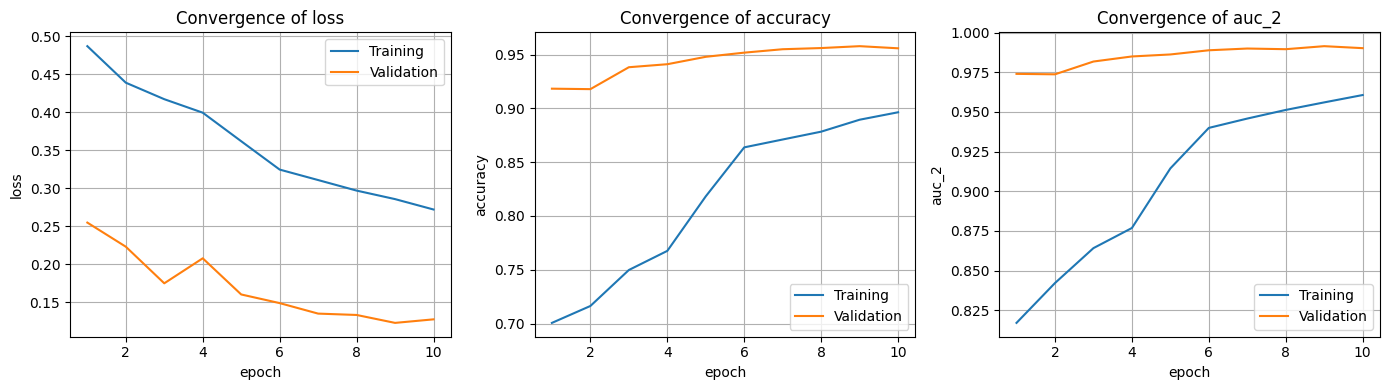

In [22]:
# monitor fine-tuning convergence
history_plot(mdl_ft_VGG16_DO)

The fine-tuning process significantly improved the performance of the model, reducing the validation loss by 67%, with the validation loss having reached a plateu at 9 epoch.

### Model based on MobileNet

For the training the models based on the features extractor MobileNet, we will apply a different approach for the transfer-learning workflow:
* Instantiate a base model and load random weights into it.
* Unfreeze all layers in the base model by setting `trainable = True`.
* Create a new model on top from the base model.
* Train the whole new model end-to-end on your new dataset.

This method is recommended for base models that contain `BatchNormalization` layers (i.e, MobileNet). Otherwise when unfreezing the model in order to do fine-tuning, each `BatchNormalization` layers must be set in inference mode by passing `training=False` when calling the base model, to avoid destroying what the model has learned.

#### Base Model MobileNet + MLP Classifier with BatchNormalizer Regularization

##### 1. Initiation

In [49]:
# Set seeds to ensure repeatibility of results
tf.random.set_seed(42)

# Pre-set the weights for the features extractor MobileNet
fe_MobileNet = keras.applications.MobileNet(
    input_shape=(96,96,3),
    include_top=False,
    pooling = None,
    weights=None
    )

# Display the base model architecture
fe_MobileNet.summary()

# Unfreeze the base model weights
fe_MobileNet.trainable = True

# Define the classifier on top of base model MobileNet
seq_MobileNet_BN = Sequential([
                  # features extractor
                  fe_MobileNet,

                  # classifier
                  BatchNormalization(),
                  Flatten(),
                  Dense(16, activation='relu'),
                  BatchNormalization(),
                  Dense(8, activation='relu'),
                  BatchNormalization(),
                  Dense(2, activation='softmax')
                  ])

# Display the new model architecture
seq_MobileNet_BN.summary()

# Compile the new model
seq_MobileNet_BN.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.00005), metrics=['accuracy', tf.keras.metrics.AUC()])

Model: "mobilenet_1.00_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 48, 48, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 48, 48, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 48, 48, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 48, 48, 32)  

##### 2. Training on new data

In [50]:
# Set a time counter
%%time

# Set checkpointer
checkpointer = ModelCheckpoint(
                              filepath = '/content/drive/MyDrive/seq_MobileNet_BN_weights_best.keras',
                              verbose = 1,
                              save_best_only=True
                              )

# Train whole model end-to-end
mdl_MobileNet_BN = seq_MobileNet_BN.fit(
                    x = tf_train,
                    steps_per_epoch = tf_train_batch,
                    epochs = 20,
                    validation_data = tf_valid,
                    validation_steps = tf_valid_batch,
                    verbose = 1,
                    callbacks=[checkpointer]
                    )

Epoch 1/20
2751/2751 [==============================] - ETA: 0s - loss: 0.5384 - accuracy: 0.7416 - auc_10: 0.8102
Epoch 1: val_loss improved from inf to 0.46316, saving model to /content/drive/MyDrive/seq_MobileNet_BN_weights_best.keras
2751/2751 [==============================] - 166s 56ms/step - loss: 0.5384 - accuracy: 0.7416 - auc_10: 0.8102 - val_loss: 0.4632 - val_accuracy: 0.7860 - val_auc_10: 0.8625
Epoch 2/20
2750/2751 [============================>.] - ETA: 0s - loss: 0.4640 - accuracy: 0.7838 - auc_10: 0.8619
Epoch 2: val_loss improved from 0.46316 to 0.43328, saving model to /content/drive/MyDrive/seq_MobileNet_BN_weights_best.keras
2751/2751 [==============================] - 151s 55ms/step - loss: 0.4640 - accuracy: 0.7838 - auc_10: 0.8619 - val_loss: 0.4333 - val_accuracy: 0.8013 - val_auc_10: 0.8813
Epoch 3/20
2750/2751 [============================>.] - ETA: 0s - loss: 0.4315 - accuracy: 0.8038 - auc_10: 0.8824
Epoch 3: val_loss improved from 0.43328 to 0.40510, savin

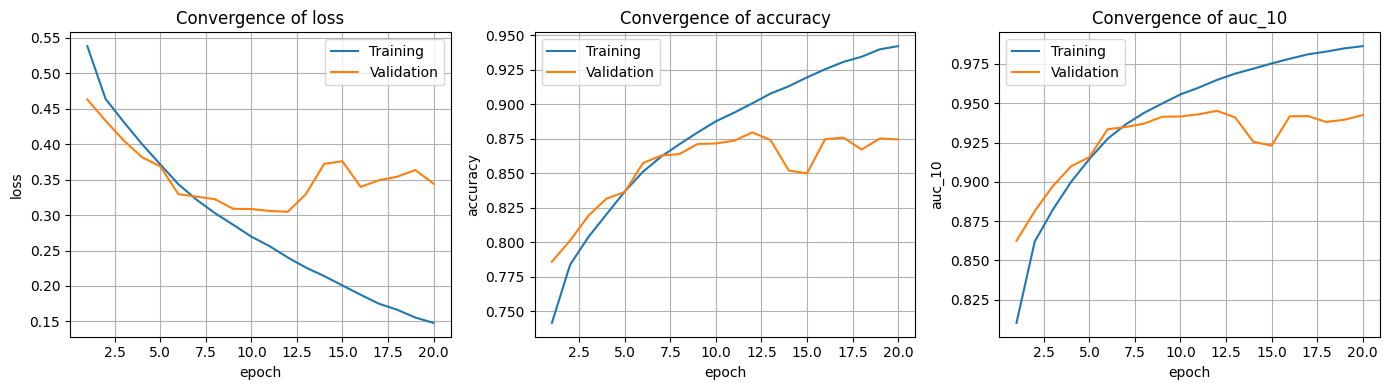

In [51]:
# monitor training convergence
history_plot(mdl_MobileNet_BN)

From the convergence graphs, we can observe that the model was steadily learning, however, from the 12th epoch onwards the validation loss began to increase, a possible indication of overfitting.

#### Base Model MobileNet + MLP Classifier with Dropout Regularization

##### 1. Initiation

In [14]:
# set seeds to ensure repeatibility of results
tf.random.set_seed(42)

# Pre-set the weights for the features extractor MobileNet
fe_MobileNet = keras.applications.MobileNet(
    input_shape=(96,96,3),
    include_top=False,
    pooling = None,
    weights=None
    )

# Display the base model architecture
fe_MobileNet.summary()

# Unfreeze the base model weights
fe_MobileNet.trainable = True

# Define the classifier model on top of MobileNet base model
seq_MobileNet_DO = Sequential([
                  # features extractor
                  fe_MobileNet,

                  # classifier
                  Dropout(0.3),
                  Flatten(),
                  Dense(16, activation='relu'),
                  Dropout(0.5),
                  Dense(8, activation='relu'),
                  Dropout(0.5),
                  Dense(2, activation='softmax')
                  ])

# Display the new model
seq_MobileNet_DO.summary()

# Compile the new model
seq_MobileNet_DO.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.00005), metrics=['accuracy', tf.keras.metrics.AUC()])

Model: "mobilenet_1.00_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 48, 48, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 48, 48, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 48, 48, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 48, 48, 32)  

##### 2. Training on new data

In [15]:
# Set a time counter
%%time

# Set checkpointer
checkpointer = ModelCheckpoint(
                              filepath = '/content/drive/MyDrive/seq_MobileNet_DO_weights_best.keras',
                              verbose = 1,
                              save_best_only=True
                              )

# Train whole model the end-to-end
mdl_MobileNet_DO = seq_MobileNet_DO.fit(
                    x = tf_train,
                    steps_per_epoch = tf_train_batch,
                    epochs = 20,
                    validation_data = tf_valid,
                    validation_steps = tf_valid_batch,
                    verbose = 1,
                    callbacks=[checkpointer]
                    )

Epoch 1/20
2750/2751 [============================>.] - ETA: 0s - loss: 0.6356 - accuracy: 0.6329 - auc: 0.6873
Epoch 1: val_loss improved from inf to 0.52878, saving model to /content/drive/MyDrive/seq_MobileNet_DO_weights_best.keras
2751/2751 [==============================] - 177s 58ms/step - loss: 0.6356 - accuracy: 0.6329 - auc: 0.6874 - val_loss: 0.5288 - val_accuracy: 0.7655 - val_auc: 0.8424
Epoch 2/20
2750/2751 [============================>.] - ETA: 0s - loss: 0.5750 - accuracy: 0.7117 - auc: 0.7743
Epoch 2: val_loss improved from 0.52878 to 0.48671, saving model to /content/drive/MyDrive/seq_MobileNet_DO_weights_best.keras
2751/2751 [==============================] - 149s 54ms/step - loss: 0.5749 - accuracy: 0.7117 - auc: 0.7744 - val_loss: 0.4867 - val_accuracy: 0.7818 - val_auc: 0.8616
Epoch 3/20
2751/2751 [==============================] - ETA: 0s - loss: 0.5543 - accuracy: 0.7188 - auc: 0.7919
Epoch 3: val_loss did not improve from 0.48671
2751/2751 [====================

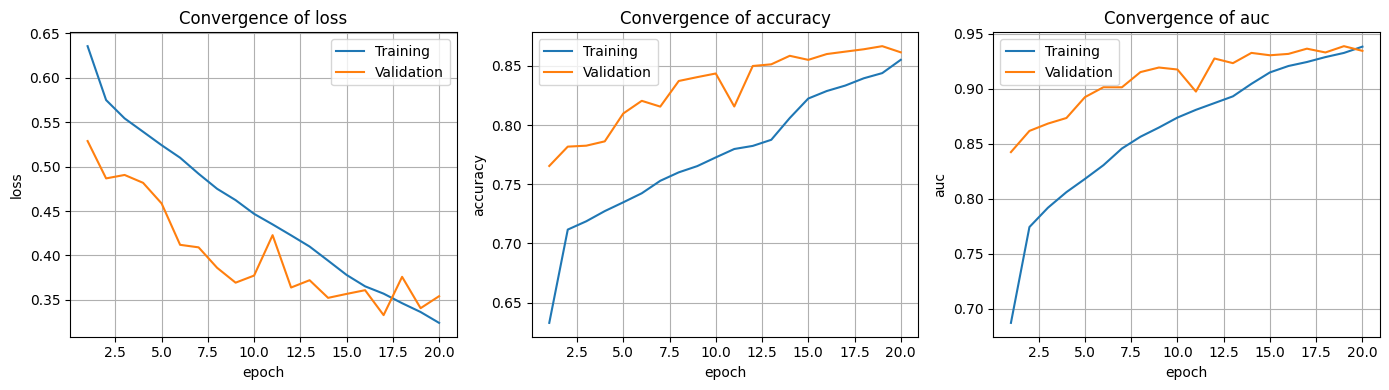

In [16]:
# monitor training convergence
history_plot(mdl_MobileNet_DO)

From the convergence plots, we can observe that the training model was learning sharply, however, from the 14th epoch onwards, the `validation loss` has leveled off with some oscillations. The rate of improvement in the `validation accuracy` and `validation auc` might have peaked at the 19th epoch.

As in the previous case, the presence of `dropout` regularization in the model achitecture made the `validation loss` to be lower than the `training loss`.

## Results and Analysis

In this section, we will summarize the results and compare the predictive models performance, and any other explanatory knowledge provided by the models setup.

### Load Best Models

Let's upload the models with the best validation loss.

In [42]:
# Load the best models
bst_mdl_VGG16_BN = tf.keras.models.load_model('/content/drive/MyDrive/seq_VGG16_BN_2_weights_best.keras')
bst_mdl_VGG16_DO = tf.keras.models.load_model('/content/drive/MyDrive/seq_VGG16_DO_2_weights_best.keras')
bst_mdl_MobileNet_BN = tf.keras.models.load_model('/content/drive/MyDrive/seq_MobileNet_BN_weights_best.keras')
bst_mdl_MobileNet_DO = tf.keras.models.load_model('/content/drive/MyDrive/seq_MobileNet_DO_weights_best.keras')

### Validation Performance Comparison

Now, let's compare the predictive performance of each model using the validation set to get an understanding of which model architecture works best.

#### Comparing metrics performance

First, let's evaluate the performance of each model against the validation set and generate their score metrics.

In [43]:
# get scores from validation set
score_16BN = bst_mdl_VGG16_BN.evaluate(tf_valid)
score_16DO = bst_mdl_VGG16_DO.evaluate(tf_valid)
score_MNBN = bst_mdl_MobileNet_BN.evaluate(tf_valid)
score_MNDO = bst_mdl_MobileNet_DO.evaluate(tf_valid)

688/688 [==============================] - 32s 44ms/step - loss: 0.3328 - accuracy: 0.8621 - auc: 0.9363


Now, let's plot and compare the models performance for each metric.

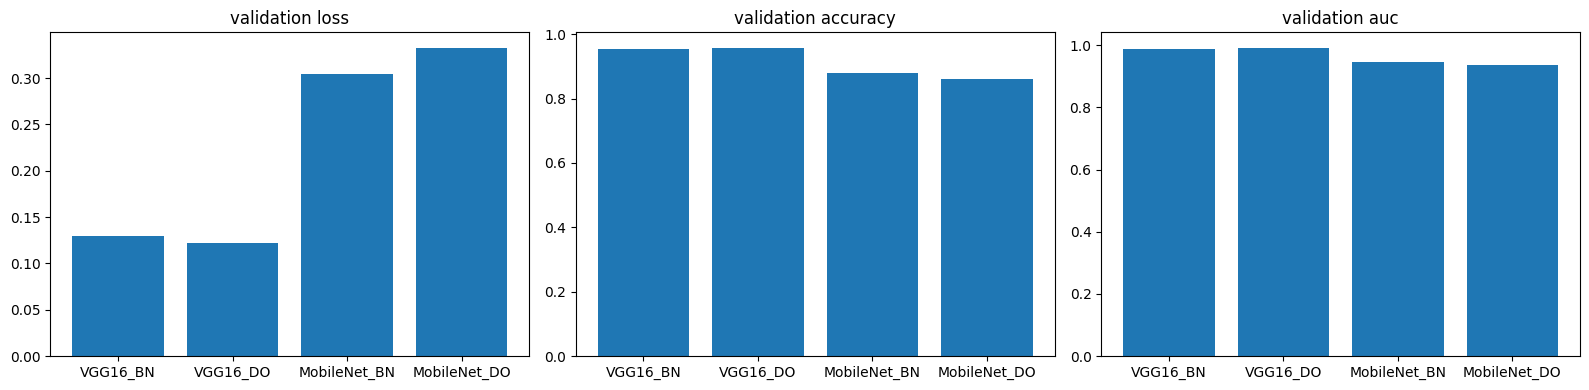

In [44]:
# plot the metrics
## list of model description
mdl_list = ['VGG16_BN', 'VGG16_DO', 'MobileNet_BN', 'MobileNet_DO']
## metric list
metric_list = ['validation loss', 'validation accuracy', 'validation auc']

## set plot size
plt.figure(figsize=[16,4])
for i in range(len(metric_list)):
  ### plot metric values
  plt.subplot(1,3,i+1)
  names = mdl_list
  values = [score_16BN[i], score_16DO[i], score_MNBN[i], score_MNDO[i]]
  plt.bar(range(len(mdl_list)), values, tick_label=names)
  plt.title(metric_list[i])

plt.tight_layout()
plt.show()

From the graphs, we can observe that the best models are those models:

* with `VGG16` base model
* trained in two stages, partial and fine-tuning

Regarding *regularization*, the classifier architecture with `Dropout` regularization performed slightly better compared to the one with `BatchNormalizer` regularization.

However, the other models trained using `MobileNet` base model perfomed quite well too, especially regarding to `auc`, even though they were trained in 39% less time than those using `VGG16` base model.  

Finally, the best model was `VGG16DO` as it achieved the lowest `validation loss`, the highest `validation accuracy`, and `validation auc`.

#### Wall Time Comparison

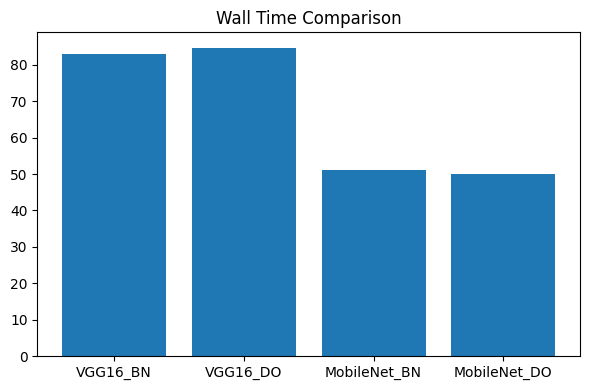

In [45]:
# manually collected Wall Time for each model training
## initial training + fine-tuning
wt_VGG16_BN = 37.083 + 45.933
wt_VGG16_DO = 36.866 + 47.8
## whole model end-to-end training
wt_MobileNet_BN = 50.983
wt_MobileNet_DO = 50.1

## set plot size
plt.figure(figsize=[6,4])
names = mdl_list
values = [wt_VGG16_BN, wt_VGG16_DO, wt_MobileNet_BN, wt_MobileNet_DO]
plt.bar(range(len(mdl_list)), values, tick_label=names)
plt.title('Wall Time Comparison')

plt.tight_layout()
plt.show()

Those models trained in two stages took longer to train than those trained in a single stage. However, it might be because of the difference in the learning rate and number of epochs. Therefore, increasing training epochs for the `MobileNet` based models with a lower training rate might help to improve their performance.

Moreover, there is no clear indication that the difference in the regularization is contributing factor in the increase or dicrease of the training time.

#### Confusion Matrix Comparison

To further evaluate the quality of the prediction, let's generate a confusion matrix for each model, and compare them.

In [46]:
# predict each model class probabilities
y_prob_16BN = bst_mdl_VGG16_BN.predict(tf_valid)
y_prob_16DO = bst_mdl_VGG16_DO.predict(tf_valid)
y_prob_MNBN = bst_mdl_MobileNet_BN.predict(tf_valid)
y_prob_MNDO = bst_mdl_MobileNet_DO.predict(tf_valid)

688/688 [==============================] - 30s 42ms/step


In [56]:
# determine the predominant class
y_pred_16BN = np.argmax(y_prob_16BN, axis=1)
y_pred_16DO = np.argmax(y_prob_16DO, axis=1)
y_pred_MNBN = np.argmax(y_prob_MNBN, axis=1)
y_pred_MNDO = np.argmax(y_prob_MNDO, axis=1)

y_pred_list = [y_pred_16BN, y_pred_16DO, y_pred_MNBN, y_pred_MNDO]
y_true = df_valid['label'].astype('int')

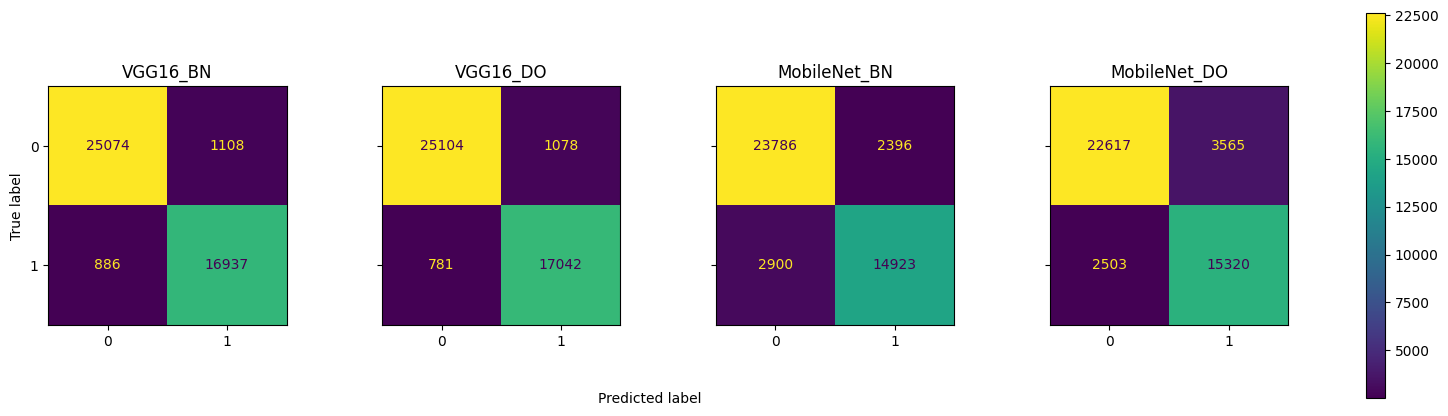

In [72]:
f, axes = plt.subplots(1, 4, figsize=(20, 5), sharey='row')

for i, y_pred in enumerate(y_pred_list):
  cf_matrix = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(cf_matrix)
  disp.plot(ax=axes[i])
  disp.ax_.set_title(mdl_list[i])
  disp.im_.colorbar.remove()
  disp.ax_.set_xlabel('')
  if i!=0:
      disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)

f.colorbar(disp.im_, ax=axes)
plt.show()

In line with the previous observed results, the model `VGG16_DO` is the best model among the trained models. It is important to highlight that this model shows the lowest number of false-negative, a critical factor in medical diagnosis.

#### Visualize Prediction

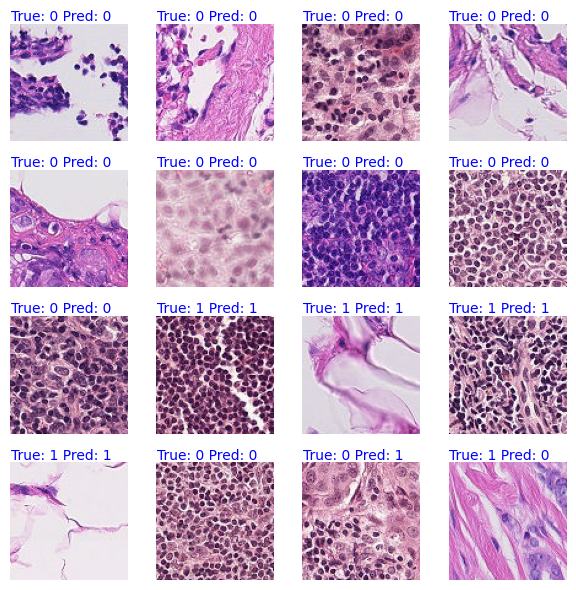

In [77]:
# set random seed for repeatibility of results
np.random.seed(42)

# Plot a random sample of 16 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(6, 6))

for i, index in enumerate(np.random.choice(df_valid.shape[0], size=16, replace=False)):
    # Display each image
    img = mpimg.imread(f'/kaggle/input/histopathologic-cancer-detection/train/{df_valid.iloc[index][0]}.tif')
    label_true = df_valid.iloc[i][1]
    label_pred = y_pred_16DO[i]

    plt.subplot(4,4,i+1)
    plt.imshow(img)
    plt.text(0, -3, f'True: {label_true} Pred: {label_pred}', color='b')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Prepare Submission File for Kraggle

In [48]:
# prediction of label probability by best model
y_prob_test_16BN = bst_mdl_VGG16_BN.predict(tf_test)
y_prob_test_16DO = bst_mdl_VGG16_DO.predict(tf_test)
y_prob_test_MNBN = bst_mdl_MobileNet_BN.predict(tf_test)
y_prob_test_MNDO = bst_mdl_MobileNet_DO.predict(tf_test)

# read sample submission file
fs_16BN = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
fs_16DO = fs_16BN.copy()
fs_MNBN = fs_16BN.copy()
fs_MNDO = fs_16BN.copy()

# input predicted values
fs_16BN.label = y_prob_test_16BN[:,1]
fs_16DO.label = y_prob_test_16DO[:,1]
fs_MNBN.label = y_prob_test_MNBN[:,1]
fs_MNDO.label = y_prob_test_MNDO[:,1]

# display one end result
fs_16BN.head()

898/898 [==============================] - 38s 43ms/step


,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.000485
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.076083
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.000823
3,2c35657e312966e9294eac6841726ff3a748febf,0.000139
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.019606


In [49]:
# generate the submission outfile
fs_16BN.to_csv('/content/drive/MyDrive/fs_16BN.csv', header=True, index=False)
fs_16DO.to_csv('/content/drive/MyDrive/fs_16DO.csv', header=True, index=False)
fs_MNBN.to_csv('/content/drive/MyDrive/fs_MNBN.csv', header=True, index=False)
fs_MNDO.to_csv('/content/drive/MyDrive/fs_MNDO.csv', header=True, index=False)

### Kaggle Scores and Leaderboard

Below the scores achieved by each model after submitting the files into Kaggle:

![alt text](https://github.com/rojasael/DTSA/blob/main/5511/W3_Kaggle_Mini_Project/DTSA-5511_W3_Cancer_Detection_Kaggle_Mini_Project%20-%20Kaggle%20Scores.png?raw=1)

As expected, the best score corresponds to model `VGG16DO`.

Even though the submission for final score is closed, as the competition ended long back, the best score achieved corresponds to the 418th position of the Leaderboard.

![alt text](https://github.com/rojasael/DTSA/blob/main/5511/W3_Kaggle_Mini_Project/DTSA-5511_W3_Cancer_Detection_Kaggle_Mini_Project%20-%20Kaggle%20Leaderboard.png?raw=1)

## Conclusion

In this project, we explored the capability of identifying metastatic cancer in small image patches taken from larger digital pathology scans by using different Convolutional Neural Network (CNN) architectures.

As a result of the training time and computing power require to train a CNN classifier, we decided to apply a typical transfer-learning workflow, but following two different approaches:

* A `VGG16` base Model + MLP classifier. Base model initiated with pre-trained weights, and trained in two stages (1st classifer and 2nd end-to-end).
* A `MobileNet` base model + MLP classifier. Base model initiated with random weights, and trained end-to-end in a single stage.

To find the best regularization setup for the MLP classifier, we applied two types of regularization:

* `BatchNormalizer`
* `Dropout`

For evaluating the performance of the model we defined two metrics:

* `accuracy`
* `auc`

and for the optimizer, we selected `Adam`, applied with different learning rates for each transfer-learning approach.

During the data exploration, we observed that the `train` set suffers from imbalance class. Therefore, we applied stratification when splitting the set into `training` and `validation` sets, to minimize any bias to majority class.

As a result of the model training process, we got four predictive models,  being the best model the one with the following setup:
- base model: `VGG16`
- classifier regularization: `Dropout`

However, when comparing the models performance taking into consideration the applied regulation, we didn't observe any indication of one particular regularization method having a significant effect on the model performance. Those models with the same base model performed quite similar with both types of regularization.

The best model `VGG16_DO` achieved an `accuracy` of 97.78%, and an `auc` of 99.15% against the `validation` set. Additionally, when comparing the models using their confusion matrix, `VGG16_DO` was the model with lowest number of false-negative cases, a critical factor in medical diagnosis.

Furthermore, when submitted into Kaggle, the predicted probabilities after evaluating the `test` set, the best model `VGG16_DO` achieved a public score of 0.9582, placing the model's results around the position 418.

The achieved results demonstrate that CNNs are powerful tools for processing images and classifying them. With more time, we could explore some alternatives to optimize the performance of the models, such as increasing the training epochs, testing different optimizers beyond `Adam`, different learning rates, different training/validation ratios, different base models, or classifier setups.